# Step 1: Import Libraries & Set Processing Device


In [7]:

# Libraries

import os
from time import time
from tqdm import tqdm
import numpy as np

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import EfficientNet_V2_M_Weights
from torchvision.models import efficientnet_v2_m
from torchvision.transforms import transforms
import torch
from torch.utils.data import random_split
from torch.cuda.amp import GradScaler, autocast


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Step 2: Load Data
#### A. Data Transformer
#### B. Create Dataset
#### C. Data Loader

In [8]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0,translate=(0.05,0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 测试数据的 transforms
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
dataset_train_path = "../training"
dataset = ImageFolder(dataset_train_path)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size


In [10]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_test

In [11]:
# Data Loader
train_loader = DataLoader(train_dataset, batch_size = 30, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=30, shuffle = True)

# Step 3: Build Model, Optimiser and Loss Function

In [12]:
# Model
PATH = "../model/HW4_EfficientV2_m.pth"
model = efficientnet_v2_m() # weights=EfficientNet_V2_M_Weights.DEFAULT
# print(model)

last_fc = model.classifier[-1]
in_features = last_fc.in_features

# Replace the last fully connected layer with the desired number of labels
num_labels = 10  # Change this to the number of labels in your classification problem
model.classifier[-1] = Linear(in_features, 10)

model.load_state_dict(torch.load(PATH))

model = model.to(device)
print(model)

# model = model.cuda()    # only if your system supports Nvidia CUDA

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
# Optimiser
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

# Step 4: Train & Evaluate the Model


In [14]:
scaler = GradScaler()

for epoch in range(3):
    print(f"\nEpoch: {epoch}")
    
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch" , desc='Training') as tepoch:
        for xtrain, ytrain in tepoch:
            torch.cuda.empty_cache()
            optimizer.zero_grad()            
            
            xtrain , ytrain_gpu = xtrain.to(device) ,  ytrain.to(device)
            
            # Step 6: Perform forward pass and calculate loss
            with autocast():
                train_prob = model(xtrain)
                loss = loss_fn(train_prob, ytrain_gpu)

           
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # training ends
            train_prob = train_prob.cpu()
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / train_size
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch" , desc='Testing') as test_epoch:
            for xtest, ytest in test_epoch:
                torch.cuda.empty_cache()
                xtest = xtest.to(device)
                test_prob = model(xtest)
                test_prob = test_prob.cpu()
                
                test_pred = torch.max(test_prob,1).indices
                test_acc += int(torch.sum(test_pred == ytest))
                
            ep_test_acc = test_acc / val_size
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Time: {duration}, Loss: {loss:.2f}\nTrain_acc: {ep_tr_acc*100 :.2f}, Test_acc: {ep_test_acc*100 :.2f}")


Epoch: 0


Testing: 100%|██████████| 168/168 [00:40<00:00,  4.18batch/s]


Time: 6.437438440322876, Loss: 0.01
Train_acc: 92.58, Test_acc: 95.62

Epoch: 1


Testing: 100%|██████████| 168/168 [00:39<00:00,  4.26batch/s]


Time: 6.327321298917135, Loss: 0.09
Train_acc: 96.09, Test_acc: 95.13

Epoch: 2


Testing: 100%|██████████| 168/168 [00:41<00:00,  4.06batch/s]

Time: 6.4943657676378885, Loss: 0.01
Train_acc: 96.80, Test_acc: 95.56


In [15]:

torch.save(model.state_dict(), PATH)


# Model Performance on Samples

In [16]:
# Image Samples

sample_1 = '../training/butterfly/OIP--04ndbWy7I04gsPgu9qOeQHaHs.jpeg'
sample_2 = '../training/chicken/1000.jpeg'
sample_3 = "../training/cow/OIP-017eIsUPeFIH7OtCeMhj5AHaFj.jpeg"
sample_4 = "../training/elephant/OIP--J2N0j1s_f3LgkIg4ZXQYAHaE8.jpeg"

sample_list = [sample_1,sample_2,sample_3,sample_4]

In [17]:
import os 

classes = list(os.listdir("../training/")[1:])
classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spyder',
 'squirrel']

In [18]:
def to_model_input_format(image):
    img_tensor = transform_test(image)
    img_tensor = img_tensor[np.newaxis, :]
    return img_tensor

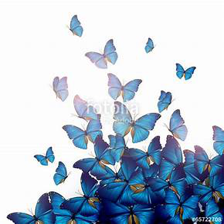

Model prediction 0, classes : butterfly


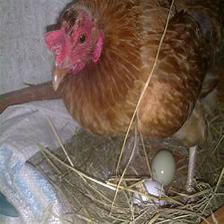

Model prediction 2, classes : chicken


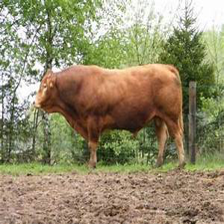

Model prediction 3, classes : cow


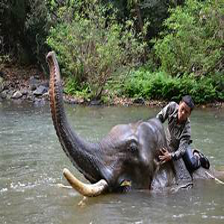

Model prediction 5, classes : elephant


In [19]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    
    img_tensor = to_model_input_format(img)
    img_tensor = img_tensor.to(device)
    
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    
    
    print(f"Model prediction {pred}, classes : {classes[pred]}")

    print("========================================================")